In [1]:
import numpy as np
import os, sys
import pickle, functools, operator
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import random #shuffle
from tensorflow.keras.utils import plot_model
import tensorflow as tf
from netCDF4 import Dataset

## Data Processing

In [2]:
def CMIPdata(Xdata, Ydata, out , myform):
    inp1 = Dataset(Xdata,'r')
    inp2 = Dataset(Ydata,'r')

    #myform = 5
    sst_1 = np.zeros((myform,140,12,24,72))
    #t300_1 = np.zeros((myform,140,12,24,72))

    #首年序列
    #i= 21个模式
    for i in range(myform):
        sst_1[i,:,:,:,:] = inp1.variables['sst1'][1+141*i:141+141*i,0:12,:,:]
        #t300_1[i,:,:,:,:] = inp1.variables['t300'][1+141*i:141+141*i,0:12,:,:]
    #(21,140,12,24,72)
    #首年序列

    
    #flatted扁平化                                             
    sst_2 = np.zeros((myform,1680,24,72))
    #t300_2 = np.zeros((myform,1680,24,72))
    for i in range(myform):
        for j in range(140):
            sst_2[i,j*12:(j+1)*12,:,:] = sst_1[i,j,:,:,:]
            #t300_2[i,j*12:(j+1)*12,:,:] = t300_1[i,j,:,:,:]
        #(21,1680,24,72)
        #每个模式 139*12+1 = 1680 个序列 序列长度为12

    #丢弃1个月 1862.1
    sst_2 = sst_2[:,1:,:,:]
    #t300_2 = t300_2[:,1:,:,:]#(form,1679,24,72)


    winsize = 12
    #winnum = 1679-winsize +1 #1668
    """跳跃六个月滑窗 = 6"""
    ts=6 
    #(1679-12)/6+1 =27
    winnum=int((1679-12)/ts +1) 

    sst_3 = np.zeros((myform, winnum, winsize, 24, 72))#(form,1668, 3, 24, 72)
    #t300_3 = np.zeros((myform, winnum, winsize, 24, 72))

    sst_3 = np.zeros((myform,winnum,12,24,72))
    #t300_3 = np.zeros((myform,winnum,12,24,72))
    for i in range(myform):
        for j in range(winnum):
            #print(j)
            sst_3[i,j,:,:,:] = sst_2[i,(j*ts):(j*ts)+winsize,:,:]
            #t300_3[i,j,:,:,:] = t300_2[i,(j*ts):(j*ts)+winsize,:,:]

    sst_4 = np.zeros((int(winnum*myform),12,24,72))
    #t300_4 = np.zeros((int(winnum*myform),12,24,72))
    for i in range(myform):
        sst_4[i*winnum:(i+1)*winnum,:,:,:] = sst_3[i,:,:,:,:]
        #t300_4[i*winnum:(i+1)*winnum,:,:,:] = t300_3[i,:,:,:,:]

    #channel = 2
    #trX = np.zeros((int(winnum*myform),12,24,72,2))
    #trX[:,:,:,:,0] = sst_4
    #trX[:,:,:,:,1] = t300_4
    trX = np.zeros((int(winnum*myform),12,1728))
    trX[:,:,:] = sst_4.reshape(int(winnum*myform),12,1728)
    #trX[:,:,:,1] = t300_4.reshape(int(winnum*myform),12,1728)
    del sst_1,sst_2,sst_3,sst_4
    #trX = trX.reshape(int(winnum*myform),12,1728)

    #保存np数组
    #(5859, 12, 24, 72, 2)
    #np.save("./CMIPdata/CMIP_trX_21_ts6_out.npy",trX) 

    #label
    #平铺
    pr_1 = np.zeros(((myform),1692))#21,1692
    for i in range(myform):
        for j in range(141):
            pr_1[i,j*12:(j+1)*12] = inp2.variables['pr'][(141*i)+j,:,0,0]
            
    #out
    pr_2 =  np.zeros((myform,winnum,out))#form,1668,1
    
    for i in range(myform):
        for j in range(winnum):
            pr_2[i,j,:] = pr_1[i,(j*ts):(j*ts)+out]

    trY = np.zeros((int(winnum*myform),out))#form*1668,1
    for i in range(myform):
        trY[i*winnum:(i+1)*winnum,:] = pr_2[i,:,:]

    #np.save("./CMIPdata/CMIP_trY_21_ts6_out%s.npy"%out,trY)
    trY_decoder_input = np.zeros((int(winnum*myform),out))
    trY_decoder_input[:,1:] = trY[:,:-1]

    #return trX[1:,:,:] ,trY.reshape(-1,24,1)[1:,:,:] ,trY_decoder_input
    return trX ,trY.reshape(-1,24,1) ,trY_decoder_input.reshape(-1,24,1)

In [3]:
def SODAdata(Xdata, Ydata, out):
    inp1 = Dataset(Xdata,'r')
    inp2 = Dataset(Ydata,'r')

    #time_step = 1 month                                               
    sst_1 = np.zeros((99,12,24,72))
    t300_1 = np.zeros((99,12,24,72))

    sst_1[:,:,:,:] = inp1.variables['sst'][1:,0:12,:,:]
    t300_1[:,:,:,:] = inp1.variables['t300'][1:,0:12,:,:]
    #(99,12,24,72)
    #1872-1970

    sst_2 = np.zeros((1188,24,72))
    t300_2 = np.zeros((1188,24,72))

    for i in range(99):
        sst_2[i*12:(i+1)*12,:,:] = sst_1[i,:,:,:]
        t300_2[i*12:(i+1)*12,:,:] = t300_1[i,:,:,:]
    #(1188,24,72)
    #丢弃一个月，便于制作滑窗序列
    sst_2 = sst_2[1:,:,:]
    t300_2 = t300_2[1:,:,:]#(1187,24,72)

    sst_3 = np.zeros((1176,12,24,72))
    t300_3 = np.zeros((1176,12,24,72))
    #滑窗
    for i in range(1176):
        sst_3[i:,:,:] = sst_2[i:i+12,:,:]
        t300_3[i,:,:,:] = t300_2[i:i+12,:,:]
    #(1176,12,24,72)


    #channel = 2
    #trX = np.zeros((1176,12,24,72,2))
    #trX[:,:,:,:,0] = sst_3
    #trX[:,:,:,:,1] = t300_3
    trX = np.zeros((1176,12,1728,2))
    trX[:,:,:,0] = sst_3.reshape(1176,12,1728)
    trX[:,:,:,1] = t300_3.reshape(1176,12,1728)
    del sst_1,sst_2,sst_3
    del t300_1,t300_2,t300_3
    trX = trX.reshape(1176,12,3456)

    #保存np数组
    #np.save("./SODAdata/SODA_trX_ts1_out.npy",trX)

    #label
    inpv2 = np.zeros((1200))
    for i in range(100):
        inpv2[i*12:(i+1)*12] = inp2.variables['pr'][i,:,0,0]
    #(1200)

    #out = 1
    trY = np.zeros((1176,out,1))
    #滑窗
    for i in range(1176):
        trY[i,:,0] = inpv2[i:i+out]   
    #(1176,out)
    trY_decoder_input = np.zeros((1176,24,1))
    trY_decoder_input[:,1:,:] = trY[:,:-1,:]

    #np.save("./SODAdata/SODA_trY_ts1_out%s.npy"%out,trY) 
    #(1176,12,24,72,2)
    #(1176,out,1)
    return trX ,trY, trY_decoder_input

In [30]:
def GOSDAdata(Xdata, Ydata, out):
    #test data
    inp11 = Dataset(Xdata,'r')
    inp22 = Dataset(Ydata,'r')
                                              
    sst_11 = np.zeros((33,12,24,72)) #1983-2015
    #t300_11 = np.zeros((33,12,24,72))

    sst_11[:,:,:,:] = inp11.variables['sst'][3:,0:12,:,:]
    #t300_11[:,:,:,:] = inp11.variables['t300'][3:,0:12,:,:]
    #(33,12,24,72)

    sst_22 = np.zeros((396,24,72))
    #t300_22 = np.zeros((396,24,72))

    for i in range(33):
        sst_22[i*12:(i+1)*12,:,:] = sst_11[i,:,:,:]
        #t300_22[i*12:(i+1)*12,:,:] = t300_11[i,:,:,:]
    #(396,24,72)
    #丢弃一个月，便于制作滑窗序列
    sst_22 = sst_22[1:,:,:]
    #t300_22 = t300_22[1:,:,:]#(395,24,72)

    #滑窗
    winsize = 12
    winnum = 395-winsize + 1 #384
    sst_33 = np.zeros((winnum, winsize, 24, 72))#(384, 12, 24, 72)
    #t300_33 = np.zeros((winnum, winsize, 24, 72))

    for i in range(winnum):
        sst_33[i,:,:,:] = sst_22[i:i+12,:,:]
        #t300_33[i,:,:,:] = t300_22[i:i+12,:,:]
    #(384,12,24,72)


    #channel = 2
    #testX = np.zeros((winnum,12,24,72,2))#384
    #testX[:,:,:,:,0] = sst_33
    #testX[:,:,:,:,1] = t300_33

    testX = np.zeros((winnum,12,1728))#384
    testX[:,:,:] = sst_33.reshape(384,12,1728)
    #testX[:,:,:,1] = t300_33.reshape(384,12,1728)
    del sst_11,sst_22,sst_33
    #del t300_11,t300_22,t300_33
    #testX = testX.reshape(384,12,3456)

    #label
    inpv22 = np.zeros((408))#2017-1984 +1=34
    for i in range(34):
        inpv22[i*12:(i+1)*12] = inp22.variables['pr'][i+2,:,0,0]# +2:从1984开始
        #(408)

    testY = np.zeros((winnum,out,1))
    #out = 1
    #滑窗
    for i in range(winnum):
        testY[i,:,0] = inpv22[i:i+out]#24
    #(384,out,1)

    return testX, testY

In [31]:
out = 24

In [5]:
#修改output长度
def set_output(Y, startout, endout):
    outlen = endout-startout+1
    trY = np.zeros((Y.shape[0],outlen,1))
    trY_decoder_input = np.zeros((Y.shape[0],outlen,1))
    
    trY = Y[:,(startout-1):endout,:]
    trY_decoder_input[:,1:,:] = trY[:,:-1,:]
    
    return trY, trY_decoder_input

In [5]:

trX, trY, trY_decoder_input= SODAdata('/home/d/Q/saconvlstm/SODA.input.36mon.1871_1970.nc', \
                                      '/home/d/Q/saconvlstm/SODA.label.12mon.1873_1972.nc', out)

In [7]:
trX.shape[0]

1176

In [8]:
trY, trY_decoder_input = set_output(trY, 10, 12)

In [5]:
myform = 21
trX1, trY1, trY_decoder_input1 = CMIPdata('/home/d/Q/saconvlstm/CMIP5.input.36mon.1861_2001.nc',\
                                          '/home/d/Q/saconvlstm/CMIP5.label.12mon.1863_2003.nc', 24,  myform)

In [7]:
trX, trY, trY_decoder_input = CMIPdata('/home/d/Q/saconvlstm/CMIP5.input.36mon.1861_2001.nc',\
                                          '/home/d/Q/saconvlstm/CMIP5.label.12mon.1863_2003.nc', 24,  myform)

In [6]:
trY1, trY_decoder_input1 = set_output(trY1, 10, 12)

NameError: name 'set_output' is not defined

In [7]:
trX = np.append(trX, trX1, axis=0)
trY = np.append(trY, trY1, axis=0)
trY_decoder_input = np.append(trY_decoder_input, trY_decoder_input1, axis=0)

In [32]:
testX, testY = GOSDAdata('/home/d/Q/saconvlstm/GODAS.input.36mon.1980_2015.nc',\
                         '/home/d/Q/saconvlstm/GODAS.label.12mon.1982_2017.nc', out)

In [13]:
testY,_ = set_output(testY, 10, 12)

In [8]:
print(trX.shape)
print(trY.shape)
print(trY_decoder_input.shape)

(5838, 12, 1728)
(5838, 24, 1)
(5838, 24, 1)


In [9]:
indices = np.arange(trX.shape[0])
np.random.shuffle(indices)
trX = trX[indices]
trY = trY[indices]

## Check data

In [54]:
trY[2000,:,:]

array([[0.5800603 ],
       [0.73728704],
       [0.99576062]])

In [55]:
trY_decoder_input[2000,:,:]

array([[0.        ],
       [0.5800603 ],
       [0.73728704]])

## Model

In [2]:
time_steps_encoder=12
#num_encoder_tokens=3456
num_encoder_tokens=1728
latent_dim=512
time_steps_decoder=24
#time_steps_decoder=3
num_decoder_tokens=1

In [ ]:
inputs = layers.Input(shape=(32,32,3))
x = layers.Conv2D(32,kernel_size=(3,3))(inputs)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(64,kernel_size=(5,5))(x)
x = layers.MaxPool2D()(x)
x = layers.Dropout(rate=0.1)(x)
x = layers.Flatten()(x)
x = layers.Dense(32,activation='relu')(x)
outputs = layers.Dense(1,activation = 'sigmoid')(x)

model = models.Model(inputs = inputs,outputs = outputs)

model.summary()

In [11]:
def custome_rmse_fn(y_true, y_pred):
    """ custome loss function
    The 24 series is not equally weighted, so log1p weighted is used.
    This is just my initial try, still have further improvement space.

    y_true: batch * 24
    """ 
    #y_pred = y_pred.numpy().reshape(-1,24)
    #y_true = y_true.numpy().reshape(-1,24)
    diff = (y_pred - y_true) ** 2
    predict_sequence_length = tf.shape(y_true)[-1]#获取序列长度
    alpha = [np.log1p(i) for i in range(1, time_steps_decoder+1)]
    #alpha = [np.log(i)*j for i,j in zip(range(1, predict_sequence_length+1), [0.65]*4+[1]*7+[1.2]*7+[1.5]*6)]
    alpha = tf.reshape(tf.convert_to_tensor(alpha, tf.float32), (1, time_steps_decoder))
    #reshape(1,24)
    rmse = tf.sqrt(tf.reduce_mean(diff * alpha))
    return rmse

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     [(None, 12, 1728)]   0                                            
__________________________________________________________________________________________________
decoder_inputs (InputLayer)     [(None, 24, 1)]      0                                            
__________________________________________________________________________________________________
endcoder_lstm (LSTM)            [(None, 12, 512), (N 4589568     encoder_inputs[0][0]             
__________________________________________________________________________________________________
decoder_lstm (LSTM)             [(None, 24, 512), (N 1052672     decoder_inputs[0][0]             
                                                                 endcoder_lstm[0][1]   

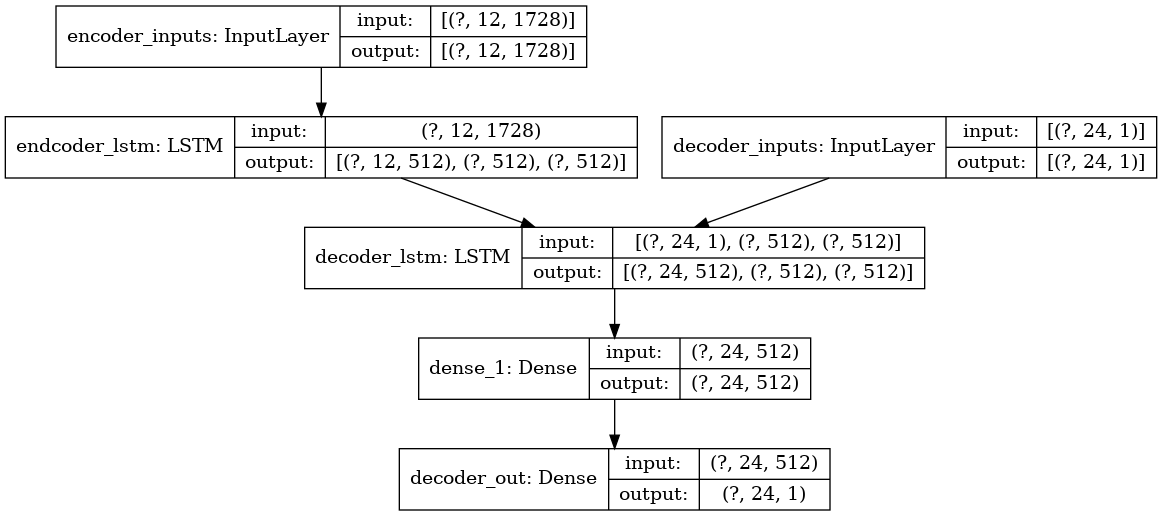

In [4]:
# Setting up the encoder
encoder_inputs = Input(shape=(time_steps_encoder, num_encoder_tokens), name="encoder_inputs")
"""后为特征数，前为批次数量！！！"""
encoder = LSTM(latent_dim, return_state=True,return_sequences=True, name='endcoder_lstm')
# 需要取得LSTM的内部state, 因此设定"return_state=True"
_, state_h, state_c = encoder(encoder_inputs)
# 我们抛弃掉`encoder_outputs`因为我们只需要LSTM cell的内部state参数
encoder_states = [state_h, state_c]

# Set up the decoder
decoder_inputs = Input(shape=(time_steps_decoder, num_decoder_tokens), name= "decoder_inputs")
# 我们设定我们的解码器回传整个输出的序列同时也回传内部的states参数
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, name='decoder_lstm')
# 我们使用`encoder_states`来做为初始值(initial state) <-- 重要
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense1 = Dense(latent_dim, activation ='tanh')
decoder_outputs = decoder_dense1(decoder_outputs)
decoder_dense = Dense(num_decoder_tokens, name='decoder_out')
decoder_outputs = decoder_dense(decoder_outputs)

# 定义一个模型接收encoder_input_data` & `decoder_input_data`做为输入而输出`decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()
plot_model(model, to_file='model_train.png', show_shapes=True, show_layer_names=True)

## Train

In [13]:
epochs=100
# Early Stopping
earlystopping = EarlyStopping(monitor='val_loss', patience = 5, restore_best_weights = True)

# Tensorboard callback
#logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
#tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

# Run training
#opt = keras.optimizers.Adam(lr = 0.0001)
#RMSprop
#当学习停滞时，减少2倍或10倍的学习率常常能获得较好的效果。
x = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1,patience=2,verbose=0,mode="auto")

model.compile(metrics=['mae'], optimizer='Adam', loss='mse')

model.fit([trX, trY_decoder_input], trY, batch_size=64, epochs=epochs, validation_split=0.1, verbose=1, callbacks=[x,earlystopping, ])

Epoch 1/100
83/83 [==============================] - 14s 170ms/step - loss: 0.4788 - mae: 0.5351 - val_loss: 0.4153 - val_mae: 0.4925
Epoch 2/100
83/83 [==============================] - 14s 167ms/step - loss: 0.3634 - mae: 0.4638 - val_loss: 0.4223 - val_mae: 0.4945
Epoch 3/100
83/83 [==============================] - 14s 167ms/step - loss: 0.2733 - mae: 0.3977 - val_loss: 0.3545 - val_mae: 0.4541
Epoch 4/100
83/83 [==============================] - 14s 168ms/step - loss: 0.1790 - mae: 0.3238 - val_loss: 0.3250 - val_mae: 0.4354
Epoch 5/100
83/83 [==============================] - 14s 168ms/step - loss: 0.1295 - mae: 0.2760 - val_loss: 0.2934 - val_mae: 0.4148
Epoch 6/100
83/83 [==============================] - 14s 168ms/step - loss: 0.0916 - mae: 0.2322 - val_loss: 0.2819 - val_mae: 0.4042
Epoch 7/100
83/83 [==============================] - 14s 168ms/step - loss: 0.0725 - mae: 0.2067 - val_loss: 0.2839 - val_mae: 0.4041
Epoch 8/100
83/83 [==============================] - 14s 168ms

## Save Model

In [14]:
save_model_path = 'model_final'
if not os.path.exists(save_model_path):
    os.makedirs(save_model_path)

# Saving encoder as in training
encoder_model = Model(encoder_inputs, encoder_states)

# Saving decoder states and dense layer 
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense1(decoder_outputs)
decoder_outputs = decoder_dense(decoder_outputs)
#modle(input, output)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

encoder_model.summary()
decoder_model.summary()
encoder_model.save(os.path.join(save_model_path, 'encoder_model.h5'))
decoder_model.save_weights(os.path.join(save_model_path, 'decoder_model_weights.h5'))

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_inputs (InputLayer)  [(None, 12, 1728)]        0         
_________________________________________________________________
endcoder_lstm (LSTM)         [(None, 12, 512), (None,  4589568   
Total params: 4,589,568
Trainable params: 4,589,568
Non-trainable params: 0
_________________________________________________________________
Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
decoder_inputs (InputLayer)     [(None, 24, 1)]      0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 512)]        0                                  

## Load Model

In [34]:
def decode_predict(input_seq):
    # inference encoder model
    save_model_path = 'model_final'
    inf_encoder_model = load_model(os.path.join(save_model_path, 'encoder_model.h5'))
    # inference decoder model
    decoder_inputs = Input(shape=(None, num_decoder_tokens))#注意是none (none, 1)
    decoder_dense1 = Dense(latent_dim,activation ='tanh')
    decoder_dense = Dense(num_decoder_tokens)
    decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
    decoder_state_input_h = Input(shape=(latent_dim,))
    decoder_state_input_c = Input(shape=(latent_dim,))
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
    decoder_states = [state_h, state_c]
    decoder_outputs = decoder_dense1(decoder_outputs)
    decoder_outputs = decoder_dense(decoder_outputs)

    inf_decoder_model = Model(
            [decoder_inputs] + decoder_states_inputs,
            [decoder_outputs] + decoder_states)
    inf_decoder_model.load_weights(os.path.join(save_model_path, 'decoder_model_weights.h5'))

    # 将输入编码为状态向量，states_value用于decoder
    states_value = inf_encoder_model.predict(input_seq.reshape(-1, 12, 1728))
    target_seq = np.zeros((1, 1, num_decoder_tokens))#(1, 1, 1)
    target_seq[0, 0, 0] = 0.
    decoded_sentence = []
    
    for i in range(24):
      #print(target_seq)
      output, h, c = inf_decoder_model.predict([target_seq] + states_value)
      #加入预测值
      decoded_sentence.append(output[0,0,0])
      
      
      # 更新目标序列（长度为1）。
      target_seq = np.zeros((1, 1, num_decoder_tokens))
      target_seq = output
      
      # Update states
      states_value = [h, c]

    return decoded_sentence

## Project


In [35]:
out = []
for i in range(testX.shape[0]):
    print("test No." + str(i+1))
    out.append(decode_predict(testX[i,:,:]))

test No.1
test No.2
test No.3
test No.4
test No.5
test No.6
test No.7
test No.8
test No.9
test No.10
test No.11
test No.12
test No.13
test No.14
test No.15
test No.16
test No.17
test No.18
test No.19
test No.20
test No.21
test No.22
test No.23
test No.24
test No.25
test No.26
test No.27
test No.28
test No.29
test No.30
test No.31
test No.32
test No.33
test No.34
test No.35
test No.36
test No.37
test No.38
test No.39
test No.40
test No.41
test No.42
test No.43
test No.44
test No.45
test No.46
test No.47
test No.48
test No.49
test No.50
test No.51
test No.52
test No.53
test No.54
test No.55
test No.56
test No.57
test No.58
test No.59
test No.60
test No.61
test No.62


test No.63
test No.64
test No.65
test No.66
test No.67
test No.68
test No.69
test No.70
test No.71
test No.72
test No.73
test No.74
test No.75
test No.76
test No.77
test No.78
test No.79
test No.80
test No.81
test No.82
test No.83
test No.84
test No.85
test No.86
test No.87
test No.88
test No.89
test No.90
test No.91
test No.92
test No.93
test No.94
test No.95
test No.96
test No.97
test No.98
test No.99
test No.100
test No.101
test No.102
test No.103
test No.104
test No.105
test No.106
test No.107
test No.108
test No.109
test No.110
test No.111
test No.112
test No.113
test No.114
test No.115
test No.116
test No.117
test No.118
test No.119
test No.120
test No.121
test No.122
test No.123


test No.124
test No.125
test No.126
test No.127
test No.128
test No.129
test No.130
test No.131
test No.132
test No.133
test No.134
test No.135
test No.136
test No.137
test No.138
test No.139
test No.140
test No.141
test No.142
test No.143
test No.144
test No.145
test No.146
test No.147
test No.148
test No.149
test No.150
test No.151
test No.152
test No.153
test No.154
test No.155
test No.156
test No.157
test No.158
test No.159
test No.160
test No.161
test No.162
test No.163
test No.164
test No.165
test No.166
test No.167
test No.168
test No.169
test No.170
test No.171
test No.172
test No.173
test No.174
test No.175
test No.176
test No.177
test No.178
test No.179
test No.180
test No.181
test No.182
test No.183
test No.184


test No.185
test No.186
test No.187
test No.188
test No.189
test No.190
test No.191
test No.192
test No.193
test No.194
test No.195
test No.196
test No.197
test No.198
test No.199
test No.200
test No.201
test No.202
test No.203
test No.204
test No.205
test No.206
test No.207
test No.208
test No.209
test No.210
test No.211
test No.212
test No.213
test No.214
test No.215
test No.216
test No.217
test No.218
test No.219
test No.220
test No.221
test No.222
test No.223
test No.224
test No.225
test No.226
test No.227
test No.228
test No.229
test No.230
test No.231
test No.232
test No.233
test No.234
test No.235
test No.236
test No.237
test No.238
test No.239
test No.240
test No.241
test No.242
test No.243
test No.244
test No.245


test No.246
test No.247
test No.248
test No.249
test No.250
test No.251
test No.252
test No.253
test No.254
test No.255
test No.256
test No.257
test No.258
test No.259
test No.260
test No.261
test No.262
test No.263
test No.264
test No.265
test No.266
test No.267
test No.268
test No.269
test No.270
test No.271
test No.272
test No.273
test No.274
test No.275
test No.276
test No.277
test No.278
test No.279
test No.280
test No.281
test No.282
test No.283
test No.284
test No.285
test No.286
test No.287
test No.288
test No.289
test No.290
test No.291
test No.292
test No.293
test No.294
test No.295
test No.296
test No.297
test No.298
test No.299
test No.300
test No.301
test No.302
test No.303
test No.304
test No.305
test No.306


test No.307
test No.308
test No.309
test No.310
test No.311
test No.312
test No.313
test No.314
test No.315
test No.316
test No.317
test No.318
test No.319
test No.320
test No.321
test No.322
test No.323
test No.324
test No.325
test No.326
test No.327
test No.328
test No.329
test No.330
test No.331
test No.332
test No.333
test No.334
test No.335
test No.336
test No.337
test No.338
test No.339
test No.340
test No.341
test No.342
test No.343
test No.344
test No.345
test No.346
test No.347
test No.348
test No.349
test No.350
test No.351
test No.352
test No.353
test No.354
test No.355
test No.356
test No.357
test No.358
test No.359
test No.360
test No.361
test No.362
test No.363
test No.364
test No.365
test No.366
test No.367


test No.368
test No.369
test No.370
test No.371
test No.372
test No.373
test No.374
test No.375
test No.376
test No.377
test No.378
test No.379
test No.380
test No.381
test No.382
test No.383
test No.384


In [35]:
testY.shape

(384, 3, 1)

In [23]:
cor = np.zeros((3))
for i in range(3):
    cor[i] = np.corrcoef(testY.reshape(384,3)[:,i],np.array(out)[:,i])[0,1]
print(cor)

[0.49911288 0.49208205 0.46317112]


In [36]:
cor = np.zeros((24))
for i in range(24):
    cor[i] = np.corrcoef(testY.reshape(384,24)[:,i],np.array(out)[:,i])[0,1]
print(cor)

[0.94575755 0.91511131 0.87748598 0.83368102 0.78246418 0.72413583
 0.66532653 0.61530115 0.57987648 0.55846829 0.54547963 0.53228964
 0.51207692 0.48004017 0.433816   0.3762239  0.31556031 0.2613807
 0.22061745 0.19826575 0.19549343 0.20834638 0.23048234 0.25436744]


In [25]:
with open("/home/d/Q/result.txt","a") as f:
    f.write(str(cor) + "\n")

## Correlation coefficient